# Create samples

In [27]:
import os
import torch
import numpy as np
import random
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.utils_data import create_distortions_batch, distort_images, resize_crop, map_distortion_values

In [28]:
def seed_it_all(seed=42):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
seed_it_all()

In [29]:
folder_path = "temp"
files = [f for f in os.listdir(folder_path) if not f.startswith('.') and '__' not in f]

with tqdm(total=len(files), desc="Images to Distort") as pbar:
    for i, f in enumerate(files):
        img_path = os.path.join(folder_path, f)
        create_distortions_batch(img_path, folder_path, batch_size=32, counter=i)
        pbar.update(1)
        # if i == 2:
        #     break

Images to Distort:   0%|          | 0/4 [00:00<?, ?it/s]/Users/choekyelnyungmartsang/opt/anaconda3/envs/ARNIQA/lib/python3.10/site-packages/torchvision/transforms/functional.py:685: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)
Images to Distort:  75%|███████▌  | 3/4 [00:28<00:09,  9.26s/it]

# Call Dataset

In [ ]:
from data import GQIDataset
import matplotlib.pyplot as plt

df = GQIDataset(root='temp', crop=True, normalize=False)

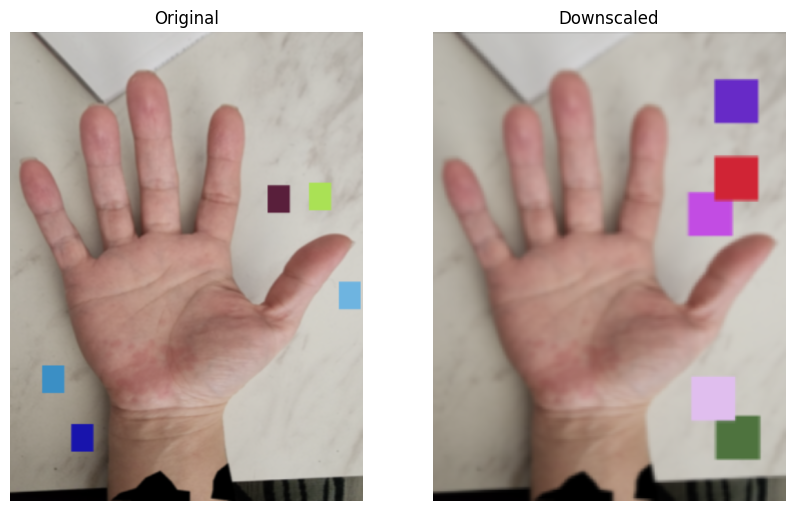

Lighting: 0.0
Focus: 0.25
Orientation: 0.25
Color: 0.25
Background: 0.5
Resolution: 0.25
FoV: 0.0


In [ ]:
sample = df[1]

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(sample["img"].permute(1, 2, 0).clip(0, 1))
plt.axis("off")
plt.title(f"Original")

plt.subplot(1,2,2)
plt.imshow(sample["img_ds"].permute(1, 2, 0).clip(0, 1))
plt.axis("off")
plt.title(f"Downscaled")

plt.show()

print(f"Lighting: {sample['label'][0].item()}")
print(f"Focus: {sample['label'][1].item()}")
print(f"Orientation: {sample['label'][2].item()}")
print(f"Color: {sample['label'][3].item()}")
print(f"Background: {sample['label'][4].item()}")
print(f"Resolution: {sample['label'][5].item()}")
print(f"FoV: {sample['label'][6].item()}")

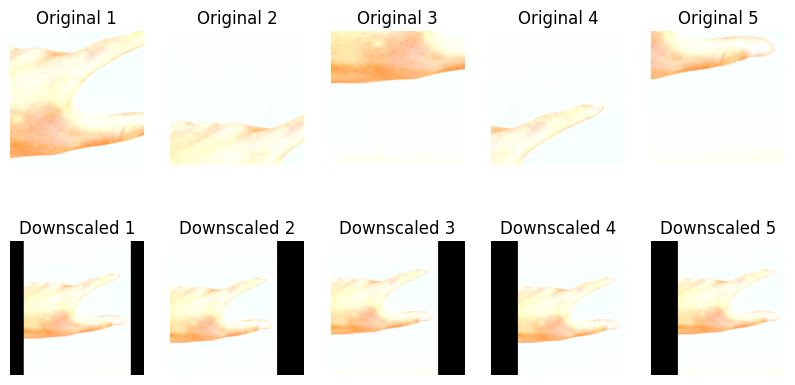

Lighting: 1.0
Focus: 0.25
Orientation: 0.75
Color: 0.5
Background: 0.0
Resolution: 0.0
FoV: 0.75


In [ ]:
index = 3
sample = df[index]

plt.figure(figsize=(10, 5))
for i in range(len(sample["img"])):
    plt.subplot(2, len(sample["img"]), i + 1)
    plt.imshow(sample["img"][i].permute(1, 2, 0).clip(0, 1))
    plt.axis("off")
    plt.title(f"Original {i + 1}")

    plt.subplot(2, len(sample["img"]), i + len(sample["img"]) + 1)
    plt.imshow(sample["img_ds"][i].permute(1, 2, 0).clip(0, 1))
    plt.axis("off")
    plt.title(f"Downscaled {i + 1}")

plt.show()
print(f"Lighting: {sample['label'][0].item()}")
print(f"Focus: {sample['label'][1].item()}")
print(f"Orientation: {sample['label'][2].item()}")
print(f"Color: {sample['label'][3].item()}")
print(f"Background: {sample['label'][4].item()}")
print(f"Resolution: {sample['label'][5].item()}")
print(f"FoV: {sample['label'][6].item()}")

# Semantic Segmentation

In [ ]:
from skimage.color import rgb2ycbcr, rgb2hsv, rgb2lab
from sklearn.mixture import GaussianMixture
from skimage.filters import threshold_otsu
from skimage.morphology import binary_opening, binary_closing, remove_small_objects, disk
from scipy.ndimage import distance_transform_edt
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
import random
import kornia
import cv2

def skin_segmentation(x: torch.Tensor) -> torch.Tensor:
    # Convert tensor to numpy array and adjust channel order for OpenCV
    x_np = x.permute(1, 2, 0).cpu().numpy()
    x_np = (x_np * 255).astype(np.uint8)  # Assuming x is in [0, 1]
    x_np = cv2.cvtColor(x_np, cv2.COLOR_RGB2BGR)

    # Converting from BGR to HSV and YCrCb color spaces
    img_HSV = cv2.cvtColor(x_np, cv2.COLOR_BGR2HSV)
    img_YCrCb = cv2.cvtColor(x_np, cv2.COLOR_BGR2YCrCb)

    # Skin color range for HSV color space
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17, 170, 255))
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    # Skin color range for YCrCb color space
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255, 180, 135))
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    # Merge skin detection (YCrCb and HSV)
    global_mask = cv2.bitwise_and(YCrCb_mask, HSV_mask)
    global_mask = cv2.medianBlur(global_mask, 3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4, 4), np.uint8))

    # Convert mask back to tensor
    global_mask = torch.from_numpy(global_mask).to(torch.float32) / 255.0

    # Apply morphological operations using skimage which expects boolean arrays
    global_mask = global_mask.bool()
    global_mask = binary_opening(global_mask, disk(2))
    global_mask = binary_closing(global_mask, disk(5))

    return global_mask

# Example usage
# Assume 'img_tensor' is your input tensor in the range [0, 1] with shape (3, H, W)
# mask_tensor = skin_segmentation(img_tensor)
  # Remove channel dimension if needed


# def color_block(x: torch.Tensor, mask: np.ndarray, background_area: float, exclusion_ratio: float = 0.3) -> torch.Tensor:
#     _, h, w = x.shape
#     patch_size = [int(max(32, min(h / 10 * background_area, h))), int(max(32, min(w / 10 * background_area, w)))]
    
#     y = x.clone()

#     # Convert numpy mask to torch tensor
#     mask_tensor = torch.from_numpy(mask).float()

#     h_max = h - patch_size[0]
#     w_max = w - patch_size[1]

#     # Define central exclusion zone
#     central_height = int(h * exclusion_ratio)
#     central_width = int(w * exclusion_ratio)
#     central_top = (h - central_height) // 2
#     central_bottom = central_top + central_height
#     central_left = (w - central_width) // 2
#     central_right = central_left + central_width

#     num_patches = max(1, int(background_area * 10))
#     attempts = 0
#     for _ in range(num_patches):
#         while True:
#             if h_max <= 0 or w_max <= 0 or attempts > 100:  # Avoid infinite loop by limiting attempts
#                 break
#             px = random.randint(0, w_max)
#             py = random.randint(0, h_max)
#             # Check if the selected area is in the background and outside the central exclusion zone
#             if not (central_left < px < central_right and central_top < py < central_bottom):
#                 patch_area = mask_tensor[py:py + patch_size[0], px:px + patch_size[1]]
#                 if torch.all(patch_area == 1):  # Ensure the entire patch is within the background
#                     color = np.random.rand(3)
#                     patch = torch.ones((3, patch_size[0], patch_size[1]), dtype=torch.float32) * torch.tensor(color, dtype=torch.float32).view(3, 1, 1)
#                     y[:, py:py + patch_size[0], px:px + patch_size[1]] = patch
#                     break
#             attempts += 1
    
#     return y
def color_block(x: torch.Tensor, mask: np.ndarray, background_area: float) -> torch.Tensor:
    _, h, w = x.shape
    patch_size = [int(max(32, min(h / 10 * background_area, h))), int(max(32, min(w / 10 * background_area, w)))]
    
    y = x.clone()

    # Convert numpy mask to torch tensor
    mask_tensor = torch.from_numpy(mask).float()

    h_max = h - patch_size[0]
    w_max = w - patch_size[1]

    num_patches = max(1, int(background_area * 10))
    attempts = 0
    for _ in range(num_patches):
        while True:
            if h_max <= 0 or w_max <= 0 or attempts > 100:  # Avoid infinite loop by limiting attempts
                break
            px = random.randint(0, w_max)
            py = random.randint(0, h_max)
            # Ensure the selected area is in the background
            if px + patch_size[1] <= w and py + patch_size[0] <= h:
                patch_area = mask_tensor[py:py + patch_size[0], px:px + patch_size[1]]
                if torch.all(patch_area == 1):  # Ensure the entire patch is within the background
                    color = np.random.rand(3)
                    patch = torch.ones((3, patch_size[0], patch_size[1]), dtype=torch.float32) * torch.tensor(color, dtype=torch.float32).view(3, 1, 1)
                    y[:, py:py + patch_size[0], px:px + patch_size[1]] = patch
                    break
            attempts += 1
    
    return y

In [ ]:
folder_path = "temp"
files = [f for f in os.listdir(folder_path) if not f.startswith('.') and '__' not in f]

In [ ]:
image_path = os.path.join(folder_path, files[3])
image = Image.open(image_path).convert('RGB') # PIL.Image.Image
a = transforms.ToTensor()(image) # torch.Size([3, 1080, 810])
b = np.array(image) # (1080, 810, 3)
skin_mask = skin_segmentation(a)

background_area = 1-skin_mask.mean().item()  # Estimate of background area
print(background_area)
if background_area > 0.05:  # Only apply distortion if significant background is present
    distorted_image = color_block(a* ~skin_mask, ~skin_mask, background_area * 2)  + a * skin_mask

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(a.permute(1, 2, 0).clip(0, 1))
plt.axis("off")
plt.title(f"Original")

plt.subplot(1, 3, 2)
plt.imshow(skin_mask)
plt.axis("off")
plt.title(f"Semantic Mask")

plt.subplot(1, 3, 3)
plt.imshow(distorted_image.permute(1, 2, 0).clip(0, 1))
plt.axis("off")
plt.title(f"Background Mask")

plt.show()

# Test single Distortions

Image Shape: torch.Size([3, 1080, 810])
Crop Shape: torch.Size([3, 540, 405])


Text(0.5, 1.0, 'Semantic Mask')

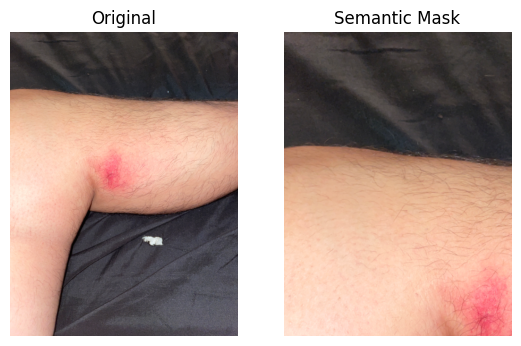

In [ ]:
def crop_image(image: torch.Tensor, level: int) -> torch.Tensor:
    _, height, width = image.shape
    if level == 0:
        return image  # No cropping for level 0.
    
    crop_ratio = level / 5
    new_height = int(height * (1 - crop_ratio / 2))
    new_width = int(width * (1 - crop_ratio / 2))

    # Crop the image towards the bottom-right corner
    cropped_image = image[:, :new_height, :new_width]
    return cropped_image

folder_path = "temp"
files = [f for f in os.listdir(folder_path) if not f.startswith('.') and '__' not in f]

image_path = os.path.join(folder_path, files[0])
image = Image.open(image_path).convert('RGB') # PIL.Image.Image
image = transforms.ToTensor()(image)
print(f"Image Shape: {image.shape}")

crop = crop_image(image, 5)
print(f"Crop Shape: {crop.shape}")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0).clip(0, 1))
plt.axis("off")
plt.title(f"Original")

plt.subplot(1, 2, 2)
plt.imshow(crop.permute(1, 2, 0).clip(0, 1))
plt.axis("off")
plt.title(f"Distorted")
plt.show()

# Plot for Report

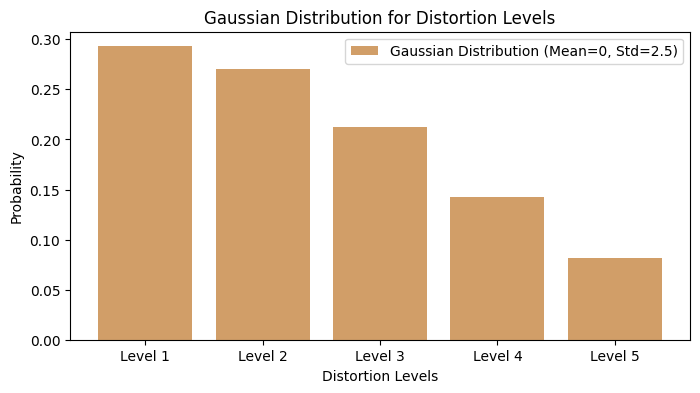

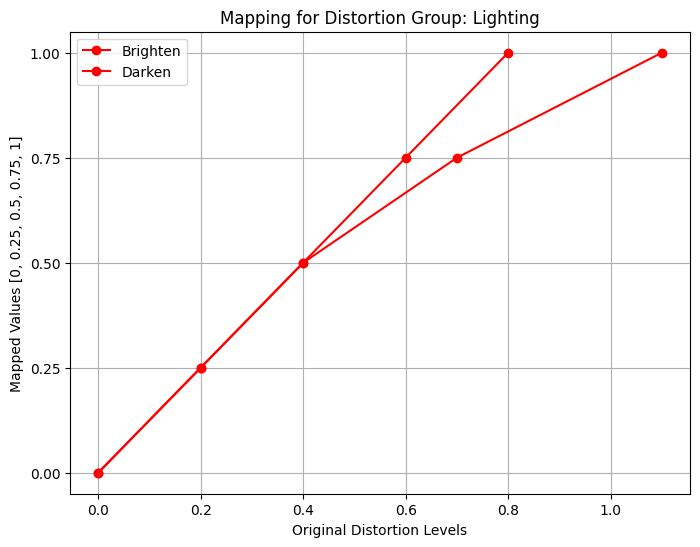

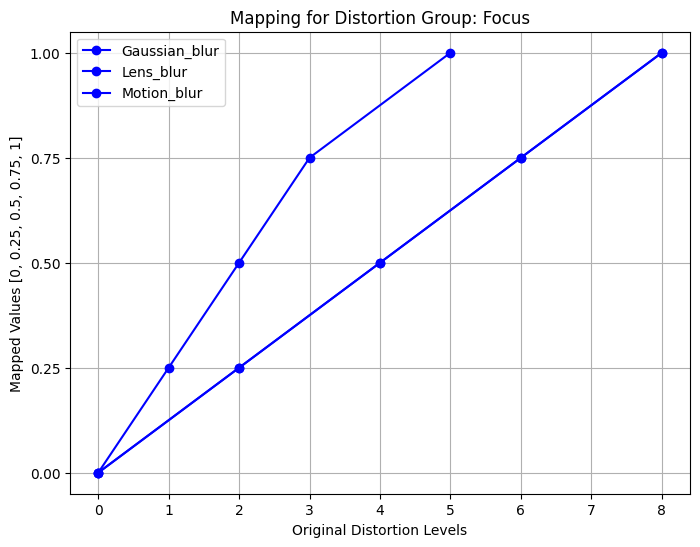

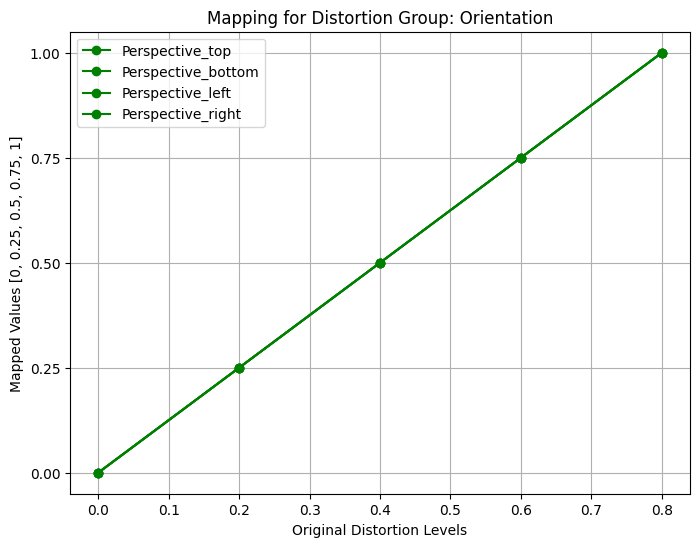

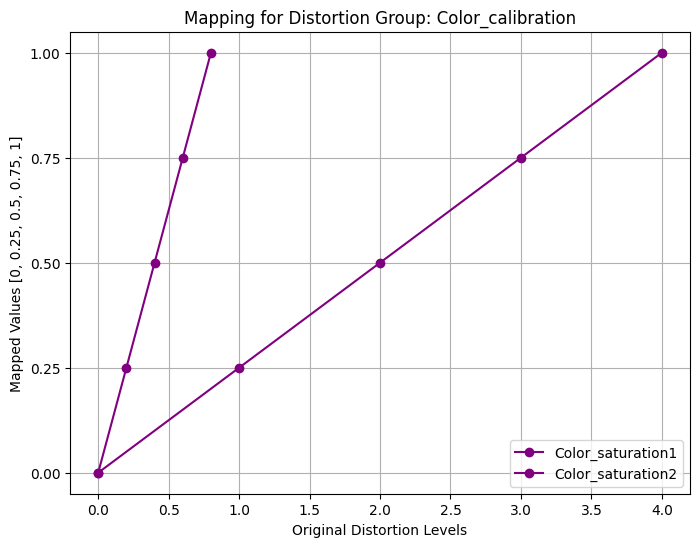

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define distortion ranges and groups for simplicity
distortion_range = {
    "gaussian_blur": [0, 1, 2, 3, 5],
    "lens_blur": [0, 2, 4, 6, 8],
    "motion_blur": [0, 2, 4, 6, 8],
    "color_saturation1": [0, 0.2, 0.4, 0.6, 0.8],
    "color_saturation2": [0, 1, 2, 3, 4],
    "brighten": [0.0, 0.2, 0.4, 0.7, 1.1],
    "darken": [0.0, 0.2, 0.4, 0.6, 0.8],
    "perspective_top": [0.0, 0.2, 0.4, 0.6, 0.8],
    "perspective_bottom": [0.0, 0.2, 0.4, 0.6, 0.8],
    "perspective_left": [0.0, 0.2, 0.4, 0.6, 0.8],
    "perspective_right": [0.0, 0.2, 0.4, 0.6, 0.8],
}
distortion_groups = {
    "lighting": ["brighten", "darken"],
    "focus": ["gaussian_blur", "lens_blur", "motion_blur"],
    "orientation": ["perspective_top", "perspective_bottom", "perspective_left", "perspective_right"],
    "color_calibration": ["color_saturation1", "color_saturation2"],
}

group_colors = {
    "lighting": 'red',
    "focus": 'blue',
    "orientation": 'green',
    "color_calibration": 'purple'
}

# Simulating Gaussian distribution to choose distortion levels
num_levels = 5
MEAN = 0
STD = 2.5
probabilities = [1 / (STD * np.sqrt(2 * np.pi)) * np.exp(-((i - MEAN) ** 2) / (2 * STD ** 2)) for i in range(num_levels)]
normalized_probabilities = [prob / sum(probabilities) for prob in probabilities]

plt.figure(figsize=(8, 4))
plt.bar(range(num_levels), normalized_probabilities, alpha=0.8, color='#C68642', label=f'Gaussian Distribution (Mean={MEAN}, Std={STD})')
plt.xlabel('Distortion Levels')
plt.ylabel('Probability')
plt.title('Gaussian Distribution for Distortion Levels')
plt.xticks(range(num_levels), labels=[f"Level {i+1}" for i in range(num_levels)])
plt.legend()
plt.grid(False)
plt.show()

# for dist, values in distortion_range.items():
#     mapped_values = [np.interp(val, values, [0, 0.25, 0.5, 0.75, 1]) for val in values]
#     plt.figure(figsize=(8, 4))
#     plt.plot(values, mapped_values, marker='o', linestyle='-')
#     plt.title(f'Mapping for {dist.replace("_", " ").title()} Distortion Levels')
#     plt.xlabel('Original Distortion Levels')
#     plt.ylabel('Mapped Values [0, 0.25, 0.5, 0.75, 1]')
#     plt.xticks(values)
#     plt.yticks([0, 0.25, 0.5, 0.75, 1])
#     plt.grid(True)
#     plt.show()

for group, distortions in distortion_groups.items():
    plt.figure(figsize=(8, 6))
    plt.title(f'Mapping for Distortion Group: {group.capitalize()}')
    plt.xlabel('Original Distortion Levels')
    plt.ylabel('Mapped Values [0, 0.25, 0.5, 0.75, 1]')
    #plt.xticks(np.arange(0, 10, 1))  # Assuming 0-9 covers the range for simplicity
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    plt.grid(True)
    
    for dist in distortions:
        values = distortion_range[dist]
        mapped_values = [np.interp(val, values, [0, 0.25, 0.5, 0.75, 1]) for val in values]
        plt.plot(values, mapped_values, marker='o', linestyle='-', label=dist.capitalize(), color=group_colors[group])
    
    plt.legend()
    plt.show()

# Combined plot for all distortions, with group-specific colors
# plt.figure(figsize=(12, 6))
# for dist, values in distortion_range.items():
#     # Find the group of the current distortion and get its assigned color
#     for group, distortions in distortion_groups.items():
#         if dist in distortions:
#             color = group_colors[group]
#             break
    
#     # Map the distortion values
#     mapped_values = [np.interp(val, values, [0, 0.25, 0.5, 0.75, 1]) for val in values]
    
#     # Plot the mapped values with the group-specific color
#     plt.plot(values, mapped_values, marker='o', linestyle='-', label=f'{dist} ({group})', color=color)

# plt.title('Combined Mapping for All Distortions with Group Colors')
# plt.xlabel('Original Distortion Levels')
# plt.ylabel('Mapped Values [0, 0.25, 0.5, 0.75, 1]')
# plt.xticks(np.arange(0, 10, 1))  # Assuming 0-9 covers the range for simplicity
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.legend()
# plt.grid(True)
# plt.show()

# Split dataset

In [ ]:
import torch
from torch.utils.data import DataLoader

from data import GQIDataset

batch_size=10
num_workers=1
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
arniqa = torch.hub.load(repo_or_dir="miccunifi/ARNIQA", source="github", model="ARNIQA")
arniqa.eval().to(device)

dataset = GQIDataset(root='temp', crop=True, normalize=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

Using cache found in /Users/choekyelnyungmartsang/.cache/torch/hub/miccunifi_ARNIQA_main


In [ ]:
import numpy as np
from tqdm import tqdm
from einops import rearrange

def get_features_scores(model: torch.nn.Module,
                        dataloader: DataLoader,
                        device: torch.device,
                        ):
    feats = np.zeros((0, model.encoder.feat_dim * 2))   # Double the features because of the original and downsampled image
    scores = np.zeros((0, 7))
    #total_iterations = len(dataloader) * dataloader.batch_size
    with tqdm(total=len(dataloader), desc="Extracting features", leave=False) as progress_bar:
        for _, batch in enumerate(dataloader):
            img_orig = batch["img"].to(device)
            img_ds = batch["img_ds"].to(device)
            label = batch["label"]
    
            img_orig = rearrange(img_orig, "b n c h w -> (b n) c h w")
            img_ds = rearrange(img_ds, "b n c h w -> (b n) c h w")
            label = torch.cat([label.repeat(5, 1) for label in batch["label"]], dim=0) # repeat label for each crop

    
            with torch.cuda.amp.autocast(), torch.no_grad():
                _, f = model(img_orig, img_ds, return_embedding=True)
    
            feats = np.concatenate((feats, f.cpu().numpy()), 0)
            scores = np.concatenate((scores, label.numpy()), 0)
            progress_bar.update(1)
    return feats, scores

features, scores = get_features_scores(arniqa, dataloader, device)
print(f"Features Shape: {features.shape}, Scores Shape: {scores.shape}")

Extracting features:   0%|          | 0/1 [00:00<?, ?it/s]/Users/choekyelnyungmartsang/opt/anaconda3/envs/ARNIQA/lib/python3.10/site-packages/torchvision/transforms/functional.py:685: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)
/Users/choekyelnyungmartsang/opt/anaconda3/envs/ARNIQA/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
                                                                  

Features Shape: (20, 4096), Scores Shape: (20, 7)


In [ ]:
scores[:4]

array([[0.75, 0.25, 0.  , 0.25, 0.25, 0.75, 0.  ],
       [0.75, 0.25, 0.  , 0.25, 0.25, 0.75, 0.  ],
       [0.75, 0.25, 0.  , 0.25, 0.25, 0.75, 0.  ],
       [0.75, 0.25, 0.  , 0.25, 0.25, 0.75, 0.  ]])

In [ ]:
features[:4]

array([[7.11680353e-02, 3.67600545e-02, 2.09380290e-03, ...,
        4.03340273e-05, 1.47631625e-03, 5.73695563e-02],
       [8.00683051e-02, 3.73957902e-02, 1.34504922e-02, ...,
        1.68326496e-05, 2.99390638e-03, 5.34551851e-02],
       [5.71020544e-02, 3.62831652e-02, 2.53382209e-03, ...,
        0.00000000e+00, 2.57986831e-03, 4.63923588e-02],
       [3.76075208e-02, 2.34947428e-02, 3.88025194e-02, ...,
        0.00000000e+00, 1.03745796e-03, 6.12727217e-02]])

In [ ]:
from sklearn.model_selection import train_test_split

num_images = 4  # You have 4 images, each with 5 crops
num_crops_per_image = 5

image_indices = np.arange(num_images)
print(f"Image Indices: {image_indices}")
train_img_indices, val_img_indices = train_test_split(image_indices, test_size=0.25, random_state=42)
print(f"Train Image Indices: {train_img_indices}, Validation Image Indices: {val_img_indices}")

Image Indices: [0 1 2 3]
Train Image Indices: [3 0 2], Validation Image Indices: [1]


In [ ]:
train_indices = np.repeat(train_img_indices * num_crops_per_image, num_crops_per_image) + np.tile(np.arange(num_crops_per_image), len(train_img_indices))
val_indices = np.repeat(val_img_indices * num_crops_per_image, num_crops_per_image) + np.tile(np.arange(num_crops_per_image), len(val_img_indices))
print(f"Train Indices: {train_indices}, Validation Indices: {val_indices}")

Train Indices: [15 16 17 18 19  0  1  2  3  4 10 11 12 13 14], Validation Indices: [5 6 7 8 9]


In [ ]:
# Now you have train_indices and val_indices that you can use to select features and scores
train_features = features[train_indices]
train_scores = scores[train_indices]
val_features = features[val_indices]
val_scores = scores[val_indices]

print(f"Train Features Shape: {train_features.shape}, Train Scores Shape: {train_scores.shape}")

Train Features Shape: (15, 4096), Train Scores Shape: (15, 7)


# Test shape

Image Size: (756, 1008), type: <class 'PIL.Image.Image'>


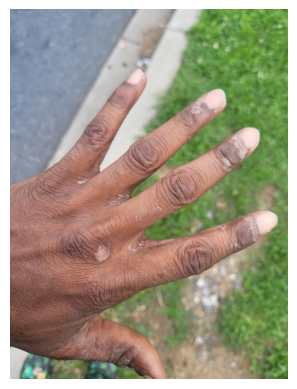

(<matplotlib.image.AxesImage at 0x14e4c9c90>,
 (-0.5, 755.5, 1007.5, -0.5),
 None)

In [1]:
import os

import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

folder_path = "temp"
files = [f for f in os.listdir(folder_path) if not f.startswith('.') and '__' not in f]


image_path = os.path.join(folder_path, files[0])
img = Image.open(image_path).convert('RGB') # PIL.Image.Image
print(f"Image Size: {img.size}, type: {type(img)}")
plt.imshow(img), plt.axis("off"), plt.show()

In [2]:
target_size = 512
width, height = img.size
aspect_ratio = width / height
if width < height:
    new_width = target_size
    new_height = int(target_size / aspect_ratio)
else:
    new_height = target_size
    new_width = int(target_size * aspect_ratio)

img = img.resize((new_width, new_height), Image.BICUBIC)
print(f"Resized Image Shape: {img.size}, type: {type(img)}")

Resized Image Shape: (512, 682), type: <class 'PIL.Image.Image'>


In [3]:
from random import randrange
import torchvision.transforms.functional as TF

def resize_crop(img, crop_size: int = 224, downscale_factor: int = 1):
    w, h = img.size
    if downscale_factor > 1:
        img = img.resize((w // downscale_factor, h // downscale_factor))
        w, h = img.size

    if crop_size is not None:
        top = randrange(0, max(1, h - crop_size))
        left = randrange(0, max(1, w - crop_size))
        img = TF.crop(img, top, left, crop_size, crop_size)     # Automatically pad with zeros if the crop is out of bounds

    return img

img_ds = resize_crop(img, crop_size=None, downscale_factor=2)
print(f"Downscaled Image Shape: {img_ds.size}, type: {type(img_ds)}")

Downscaled Image Shape: (256, 341), type: <class 'PIL.Image.Image'>


In [4]:
img = transforms.ToTensor()(img)
print(f"Resized Image Shape: {img.shape}, type: {type(img)}")
img_ds = transforms.ToTensor()(img_ds)
print(f"Downscaled Image Shape: {img_ds.shape}, type: {type(img_ds)}")

Resized Image Shape: torch.Size([3, 682, 512]), type: <class 'torch.Tensor'>
Downscaled Image Shape: torch.Size([3, 341, 256]), type: <class 'torch.Tensor'>


In [5]:
import torch
import numpy as np
import random

from utils.distortions import *

distortion_groups = {
    "lighting": ["brighten", "darken"],
    "focus": ["gaussian_blur", "lens_blur", "motion_blur"],
    "orientation": ["perspective_top", "perspective_bottom", "perspective_left", "perspective_right"],
    "color_calibration": ["color_saturation1", "color_saturation2"],
    "background": ["color_block"],
    "resolution": ["change_resolution"],
    "field_of_view": ["crop_image"],
}

distortion_groups_mapping = {
    "gaussian_blur": "focus",
    "lens_blur": "focus",
    "motion_blur": "focus",
    "color_saturation1": "color_calibration",
    "color_saturation2": "color_calibration",
    "brighten": "lighting",
    "darken": "lighting",
    "perspective_top": "orientation",
    "perspective_bottom": "orientation",
    "perspective_left": "orientation",
    "perspective_right": "orientation",
    "color_block": "background",
    "crop_image": "field_of_view",
    "change_resolution": "resolution",
}

distortion_range = {
    "gaussian_blur": [0, 1, 2, 3, 5],
    "lens_blur": [0, 2, 4, 6, 8],
    "motion_blur": [0, 2, 4, 6, 8],
    "color_saturation1": [0, 0.2, 0.4, 0.6, 0.8],
    "color_saturation2": [0, 1, 2, 3, 4],
    "brighten": [0.0, 0.2, 0.4, 0.7, 1.1],
    "darken": [0.0, 0.2, 0.4, 0.6, 0.8],
    "perspective_top": [0.0, 0.2, 0.4, 0.6, 0.8],
    "perspective_bottom": [0.0, 0.2, 0.4, 0.6, 0.8],
    "perspective_left": [0.0, 0.2, 0.4, 0.6, 0.8],
    "perspective_right": [0.0, 0.2, 0.4, 0.6, 0.8],
    "color_block": [0.0, 0.5, 1.0, 1.5, 2.0],
    "change_resolution": [0.0, 0.4, 0.6, 0.8, 1],
    "crop_image": [0, 1, 2, 3, 4],
}

distortion_functions = {
    "gaussian_blur": gaussian_blur,
    "lens_blur": lens_blur,
    "motion_blur": motion_blur,
    "color_saturation1": color_saturation1,
    "color_saturation2": color_saturation2,
    "brighten": brighten,
    "darken": darken,
    "perspective_top": perspective_top,
    "perspective_bottom": perspective_bottom,
    "perspective_left": perspective_left,
    "perspective_right": perspective_right,
    "color_block": color_block,
    "crop_image": crop_image,
    "change_resolution": change_resolution,
}

def distort_images(image: torch.Tensor, distort_functions: list = None, distort_values: list = None, num_levels: int = 5) -> torch.Tensor:
    if distort_functions is None or distort_values is None:
        distort_functions, distort_values = get_distortions_composition(num_levels)

    for distortion, value in zip(distort_functions, distort_values):
        print(f"\nApplying {distortion.__name__} with value: {value}")
        image = distortion(image, value)
        image = image.to(torch.float32)
        image = torch.clip(image, 0, 1)
        print(f"Image Shape: {image.shape}, Type: {type(image)}")

    return image, distort_functions, distort_values

def get_distortions_composition(num_levels: int = 5):
    MEAN = 0
    STD = 2.5

    # Select a random distortion from each group
    distortions = [random.choice(distortion_groups[group]) for group in list(distortion_groups.keys())]
    distort_functions = [distortion_functions[dist] for dist in distortions]

    # Compute probabilities according to a Gaussian distribution
    probabilities = [1 / (STD * np.sqrt(2 * np.pi)) * np.exp(-((i - MEAN) ** 2) / (2 * STD ** 2)) for i in range(num_levels)]
    normalized_probabilities = [prob / sum(probabilities) for prob in probabilities]

    # Select values for each distortion based on the computed probabilities
    distort_values = [np.random.choice(distortion_range[dist][:num_levels], p=normalized_probabilities) for dist in distortions]

    # Print selected distortions and their values
    print("Selected Distortions and Values:")
    for dist, value in zip(distortions, distort_values):
        print(f"{dist}: Level {value} (Group: {distortion_groups_mapping[dist]})")

    return distort_functions, distort_values


img, distort_functions, distort_values = distort_images(img)
img_ds, _, _ = distort_images(img_ds, distort_functions=distort_functions, distort_values=distort_values)

Selected Distortions and Values:
brighten: Level 0.7 (Group: lighting)
lens_blur: Level 0 (Group: focus)
perspective_right: Level 0.4 (Group: orientation)
color_saturation2: Level 1 (Group: color_calibration)
color_block: Level 1.5 (Group: background)
change_resolution: Level 1.0 (Group: resolution)
crop_image: Level 0 (Group: field_of_view)

Applying brighten with value: 0.7
Image Shape: torch.Size([3, 682, 512]), Type: <class 'torch.Tensor'>

Applying lens_blur with value: 0
Image Shape: torch.Size([3, 682, 512]), Type: <class 'torch.Tensor'>

Applying perspective_right with value: 0.4
Image Shape: torch.Size([3, 682, 512]), Type: <class 'torch.Tensor'>

Applying color_saturation2 with value: 1
Image Shape: torch.Size([3, 682, 512]), Type: <class 'torch.Tensor'>

Applying color_block with value: 1.5
Image Shape: torch.Size([3, 682, 512]), Type: <class 'torch.Tensor'>

Applying change_resolution with value: 1.0
Image Shape: torch.Size([3, 682, 512]), Type: <class 'torch.Tensor'>

Appl

/Users/choekyelnyungmartsang/opt/anaconda3/envs/ARNIQA/lib/python3.10/site-packages/torchvision/transforms/functional.py:685: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


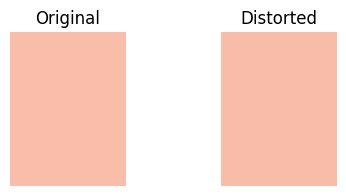

In [6]:
plt.figure(figsize=(5, 2))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0).clip(0, 1))
plt.axis("off")
plt.title(f"Original")

plt.subplot(1, 2, 2)
plt.imshow(img_ds.permute(1, 2, 0).clip(0, 1))
plt.axis("off")
plt.title(f"Distorted")
plt.show()

In [7]:
import torch
import torchvision.transforms.functional as TF
from torchvision import transforms

crop_size = 224
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def center_corners_crop(img, crop_size: int = 224):
    width, height = img.size

    # Calculate the coordinates for the center crop and the four corners
    cx, cy = width // 2, height // 2
    crops = [
        TF.crop(img, cy - crop_size // 2, cx - crop_size // 2, crop_size, crop_size),  # Center
        TF.crop(img, 0, 0, crop_size, crop_size),  # Top-left corner
        TF.crop(img, 0, width - crop_size, crop_size, crop_size),  # Top-right corner
        TF.crop(img, height - crop_size, 0, crop_size, crop_size),  # Bottom-left corner
        TF.crop(img, height - crop_size, width - crop_size, crop_size, crop_size)  # Bottom-right corner
    ]

    # Print statements to trace the cropping process
    positions = ["Center", "Top-left", "Top-right", "Bottom-left", "Bottom-right"]
    print(f"Cropping {len(crops)} images:")
    for pos, crop in zip(positions, crops):
        print(f"- {pos} crop size: {crop.size}")

    return crops

from torchvision.transforms import ToPILImage, ToTensor, Normalize

# Assuming img and img_ds are tensors
crop_size = 224
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

img_pil = ToPILImage()(img)
img_ds_pil = ToPILImage()(img_ds)

# Apply cropping
crops = center_corners_crop(img_pil, crop_size=crop_size)
crops_ds = center_corners_crop(img_ds_pil, crop_size=crop_size)

# Convert crops back to tensors and stack
crops = [ToTensor()(crop) for crop in crops]
crops_ds = [ToTensor()(crop) for crop in crops_ds]

img = torch.stack(crops, dim=0)
img_ds = torch.stack(crops_ds, dim=0)

# Print the shape of stacked images
print("Stacked Image Shape:", img.shape)
print("Stacked Downscaled Image Shape:", img_ds.shape)

# Normalize the images
img = normalize(img)
img_ds = normalize(img_ds)

# Print final shape and type after normalization
print("Final Image Shape:", img.shape, ", Type:", type(img))
print("Final Downscaled Image Shape:", img_ds.shape, ", Type:", type(img_ds))


Cropping 5 images:
- Center crop size: (224, 224)
- Top-left crop size: (224, 224)
- Top-right crop size: (224, 224)
- Bottom-left crop size: (224, 224)
- Bottom-right crop size: (224, 224)
Cropping 5 images:
- Center crop size: (224, 224)
- Top-left crop size: (224, 224)
- Top-right crop size: (224, 224)
- Bottom-left crop size: (224, 224)
- Bottom-right crop size: (224, 224)
Stacked Image Shape: torch.Size([5, 3, 224, 224])
Stacked Downscaled Image Shape: torch.Size([5, 3, 224, 224])
Final Image Shape: torch.Size([5, 3, 224, 224]) , Type: <class 'torch.Tensor'>
Final Downscaled Image Shape: torch.Size([5, 3, 224, 224]) , Type: <class 'torch.Tensor'>


In [8]:
def map_distortion_values(distort_functions, distort_values):
    distort_functions = [f.__name__ for f in distort_functions]
    mapped_values = []
    
    print("Mapping Distortion Values:")
    for func, val in zip(distort_functions, distort_values):
        range_vals = distortion_range.get(func)
        if range_vals:
            # Normalize the actual value to a scale of 0 to 1 based on its position in the range
            mapped_value = np.interp(val, range_vals, [0, 0.25, 0.5, 0.75, 1])
            mapped_values.append(mapped_value)
            print(f"{func}: Original Value = {val}, Mapped Value = {mapped_value}")
            print(f"   - Range: {range_vals} -> Normalized Scale: [0, 0.25, 0.5, 0.75, 1]")
        else:
            mapped_values.append(val)
            print(f"{func}: Original Value = {val} (No range mapping available)")

    return mapped_values

mapped_values = map_distortion_values(distort_functions, distort_values)
mapped_values = torch.tensor(mapped_values, dtype=torch.float16)

print(f"\nMapped Values: {mapped_values}, Shape: {mapped_values.shape}, Type: {type(mapped_values)}")

Mapping Distortion Values:
brighten: Original Value = 0.7, Mapped Value = 0.75
   - Range: [0.0, 0.2, 0.4, 0.7, 1.1] -> Normalized Scale: [0, 0.25, 0.5, 0.75, 1]
lens_blur: Original Value = 0, Mapped Value = 0.0
   - Range: [0, 2, 4, 6, 8] -> Normalized Scale: [0, 0.25, 0.5, 0.75, 1]
perspective_right: Original Value = 0.4, Mapped Value = 0.5
   - Range: [0.0, 0.2, 0.4, 0.6, 0.8] -> Normalized Scale: [0, 0.25, 0.5, 0.75, 1]
color_saturation2: Original Value = 1, Mapped Value = 0.25
   - Range: [0, 1, 2, 3, 4] -> Normalized Scale: [0, 0.25, 0.5, 0.75, 1]
color_block: Original Value = 1.5, Mapped Value = 0.75
   - Range: [0.0, 0.5, 1.0, 1.5, 2.0] -> Normalized Scale: [0, 0.25, 0.5, 0.75, 1]
change_resolution: Original Value = 1.0, Mapped Value = 1.0
   - Range: [0.0, 0.4, 0.6, 0.8, 1] -> Normalized Scale: [0, 0.25, 0.5, 0.75, 1]
crop_image: Original Value = 0, Mapped Value = 0.0
   - Range: [0, 1, 2, 3, 4] -> Normalized Scale: [0, 0.25, 0.5, 0.75, 1]

Mapped Values: tensor([0.7500, 0.000

In [9]:
from data import GQIDataset
from torch.utils.data import DataLoader

# Assuming img, img_ds, and mapped_values have been prepared correctly
dataset = GQIDataset(root='temp', crop=True, normalize=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

In [10]:
# Print some sample data to confirm everything is as expected
for i, sample in enumerate(dataloader):
    print(f"Batch {i}:")
    print(f"Images Shape: {sample['img'].shape}, Type: {sample['img'].dtype}")
    print(f"Downscaled Images Shape: {sample['img_ds'].shape}, Type: {sample['img_ds'].dtype}")
    print(f"Labels: {sample['label']}")
    if i == 0:  # Just print one batch for brevity
        break

Batch 0:
Images Shape: torch.Size([1, 5, 3, 224, 224]), Type: torch.float32
Downscaled Images Shape: torch.Size([1, 5, 3, 224, 224]), Type: torch.float32
Labels: tensor([[0.2500, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.7500]],
       dtype=torch.float16)


/Users/choekyelnyungmartsang/opt/anaconda3/envs/ARNIQA/lib/python3.10/site-packages/torchvision/transforms/functional.py:685: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


In [11]:
import torch
import numpy as np
from einops import rearrange

def get_features_scores(model: torch.nn.Module, dataloader: DataLoader, device: torch.device):
    feats = np.zeros((0, model.encoder.feat_dim * 2))  # Double the features
    scores = np.zeros((0, 7))  # Initialize score array assuming there are 7 scores per image
    
    for batch_index, batch in enumerate(dataloader):
        img_orig = batch["img"].to(device)
        img_ds = batch["img_ds"].to(device)
        label = batch["label"].repeat(5, 1).to(device)

        # Print initial shapes for debugging
        print(f"Batch {batch_index}: Original Image Shape: {img_orig.shape}, Downsampled Image Shape: {img_ds.shape}")
        print(f"Labels Shape After Repetition: {label.shape}")


        # Rearrange images for processing
        img_orig = rearrange(img_orig, "b n c h w -> (b n) c h w")
        img_ds = rearrange(img_ds, "b n c h w -> (b n) c h w")

        print(f"Rearranged Original Image Shape: {img_orig.shape}, Rearranged Downsampled Image Shape: {img_ds.shape}")

        with torch.cuda.amp.autocast(), torch.no_grad():
            _, f = model(img_orig, img_ds, return_embedding=True)  # Get features

        feats = np.concatenate((feats, f.cpu().numpy()), 0)
        scores = np.concatenate((scores, label.numpy()), 0)

        print(f"Updated Features Shape: {feats.shape}, Updated Scores Shape: {scores.shape}")

    return feats, scores

DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
arniqa = torch.hub.load(repo_or_dir="miccunifi/ARNIQA", source="github", model="ARNIQA")
arniqa.eval().to(DEVICE)
next(arniqa.parameters()).is_cuda
features, scores = get_features_scores(arniqa, dataloader, DEVICE)

Using cache found in /Users/choekyelnyungmartsang/.cache/torch/hub/miccunifi_ARNIQA_main
/Users/choekyelnyungmartsang/opt/anaconda3/envs/ARNIQA/lib/python3.10/site-packages/torchvision/transforms/functional.py:685: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Batch 0: Original Image Shape: torch.Size([1, 5, 3, 224, 224]), Downsampled Image Shape: torch.Size([1, 5, 3, 224, 224])
Labels Shape After Repetition: torch.Size([5, 7])
Rearranged Original Image Shape: torch.Size([5, 3, 224, 224]), Rearranged Downsampled Image Shape: torch.Size([5, 3, 224, 224])


/Users/choekyelnyungmartsang/opt/anaconda3/envs/ARNIQA/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Updated Features Shape: (5, 4096), Updated Scores Shape: (5, 7)
Batch 1: Original Image Shape: torch.Size([1, 5, 3, 224, 224]), Downsampled Image Shape: torch.Size([1, 5, 3, 224, 224])
Labels Shape After Repetition: torch.Size([5, 7])
Rearranged Original Image Shape: torch.Size([5, 3, 224, 224]), Rearranged Downsampled Image Shape: torch.Size([5, 3, 224, 224])
Updated Features Shape: (10, 4096), Updated Scores Shape: (10, 7)
Batch 2: Original Image Shape: torch.Size([1, 5, 3, 224, 224]), Downsampled Image Shape: torch.Size([1, 5, 3, 224, 224])
Labels Shape After Repetition: torch.Size([5, 7])
Rearranged Original Image Shape: torch.Size([5, 3, 224, 224]), Rearranged Downsampled Image Shape: torch.Size([5, 3, 224, 224])
Updated Features Shape: (15, 4096), Updated Scores Shape: (15, 7)
Batch 3: Original Image Shape: torch.Size([1, 5, 3, 224, 224]), Downsampled Image Shape: torch.Size([1, 5, 3, 224, 224])
Labels Shape After Repetition: torch.Size([5, 7])
Rearranged Original Image Shape: to

In [18]:
from sklearn.model_selection import train_test_split

image_indices = np.arange(len(dataset))
print(f"Total images: {len(image_indices)}")

train_img_indices, val_img_indices = train_test_split(image_indices, test_size=0.5, random_state=42, shuffle=True)
train_indices = np.repeat(train_img_indices * 5, 5) + np.tile(np.arange(5), len(train_img_indices))
val_indices = np.repeat(val_img_indices * 5, 5) + np.tile(np.arange(5), len(val_img_indices))
print("Example Training Indices:", train_indices[:10])
print("Example Validation Indices:", val_indices[:10])

train_features = features[train_indices]
train_scores = scores[train_indices]
val_features = features[val_indices]
val_scores = scores[val_indices]
val_scores = val_scores[::5]  # Scores are repeated for each crop, so we only keep the first one
orig_val_indices = val_indices[::5] // 5  # Get original indices

print("Training Features Shape:", train_features.shape)
print("Training Scores Shape:", train_scores.shape)
print("Validation Features Shape:", val_features.shape)
print("Validation Scores Shape:", val_scores.shape)

# Optional: Detailed check to ensure all crops of a single image are in the same subset
for start in range(0, len(train_img_indices) * 5, 5):
    print(f"Training group from image {train_img_indices[start//5]} (indices {train_indices[start:start+5]}):")
    print(train_scores[start:start+5])

for start in range(0, len(val_img_indices) * 5, 5):
    print(f"Validation group from image {val_img_indices[start//5]} (indices {val_indices[start:start+5]}):")
    print(val_scores[start:start+5])

Total images: 4
Example Training Indices: [ 0  1  2  3  4 10 11 12 13 14]
Example Validation Indices: [ 5  6  7  8  9 15 16 17 18 19]
Training Features Shape: (10, 4096)
Training Scores Shape: (10, 7)
Validation Features Shape: (10, 4096)
Validation Scores Shape: (2, 7)
Training group from image 0 (indices [0 1 2 3 4]):
[[0.   0.25 0.25 0.75 0.   0.5  0.25]
 [0.   0.25 0.25 0.75 0.   0.5  0.25]
 [0.   0.25 0.25 0.75 0.   0.5  0.25]
 [0.   0.25 0.25 0.75 0.   0.5  0.25]
 [0.   0.25 0.25 0.75 0.   0.5  0.25]]
Training group from image 2 (indices [10 11 12 13 14]):
[[0.75 0.25 0.25 0.25 0.   0.25 0.5 ]
 [0.75 0.25 0.25 0.25 0.   0.25 0.5 ]
 [0.75 0.25 0.25 0.25 0.   0.25 0.5 ]
 [0.75 0.25 0.25 0.25 0.   0.25 0.5 ]
 [0.75 0.25 0.25 0.25 0.   0.25 0.5 ]]
Validation group from image 1 (indices [5 6 7 8 9]):
[[0.   0.25 0.   0.75 0.   0.5  0.  ]
 [0.5  0.25 0.25 0.25 0.25 0.5  0.75]]
Validation group from image 3 (indices [15 16 17 18 19]):
[]


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats

srocc_dataset = {"global": []}
plcc_dataset = {"global": []}

regressor = LinearRegression().fit(train_features, train_scores)

predictions = regressor.predict(val_features)
print("Predictions Shape:", predictions.shape)
#p = np.mean(np.reshape(predictions, (-1, 5)), 1)  # Average the predictions of the 5 crops of the same image
#print("Predictions Shape After Averaging:", p.shape)

predictions = np.reshape(predictions, (-1, 5, 7))  # Reshape to group crops per image
predictions = np.mean(predictions, axis=1)
print("Predictions Shape After Averaging:", predictions.shape)

print("Length of Predictions:", len(predictions))
print("Length of Validation Scores:", len(val_scores))

#srocc = stats.spearmanr(predictions, val_scores)[0]  # Spearman's Rank Order Correlation Coefficient
#plcc = stats.pearsonr(predictions, val_scores)[0]  # Pearson's Linear Correlation Coefficient
#print(f"SROCC (Spearman Correlation): {srocc}")
#print(f"PLCC (Pearson Correlation): {plcc}")
#srocc_dataset["global"].append(stats.spearmanr(predictions, val_scores)[0])
#plcc_dataset["global"].append(stats.pearsonr(predictions, val_scores)[0])

srocc = []
plcc = []
for i in range(predictions.shape[1]):
    srocc_value, _ = stats.spearmanr(predictions[:, i], val_scores[:, i])
    plcc_value, _ = stats.pearsonr(predictions[:, i], val_scores[:, i])
    srocc.append(srocc_value)
    plcc.append(plcc_value)
print("SROCC (Spearman Correlation) for each score metric:", srocc)
print("PLCC (Pearson Correlation) for each score metric:", plcc)

mae = mean_absolute_error(val_scores, predictions)
mse = mean_squared_error(val_scores, predictions)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

Predictions Shape: (10, 7)
Predictions Shape After Averaging: (2, 7)
Length of Predictions: 2
Length of Validation Scores: 2
SROCC (Spearman Correlation) for each score metric: [-0.9999999999999999, nan, nan, -0.9999999999999999, nan, nan, -0.9999999999999999]
PLCC (Pearson Correlation) for each score metric: [-1.0, nan, nan, -1.0, nan, nan, -1.0]
Mean Absolute Error: 0.20471158321186747
Mean Squared Error: 0.06740355470157264


/Users/choekyelnyungmartsang/opt/anaconda3/envs/ARNIQA/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/choekyelnyungmartsang/opt/anaconda3/envs/ARNIQA/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


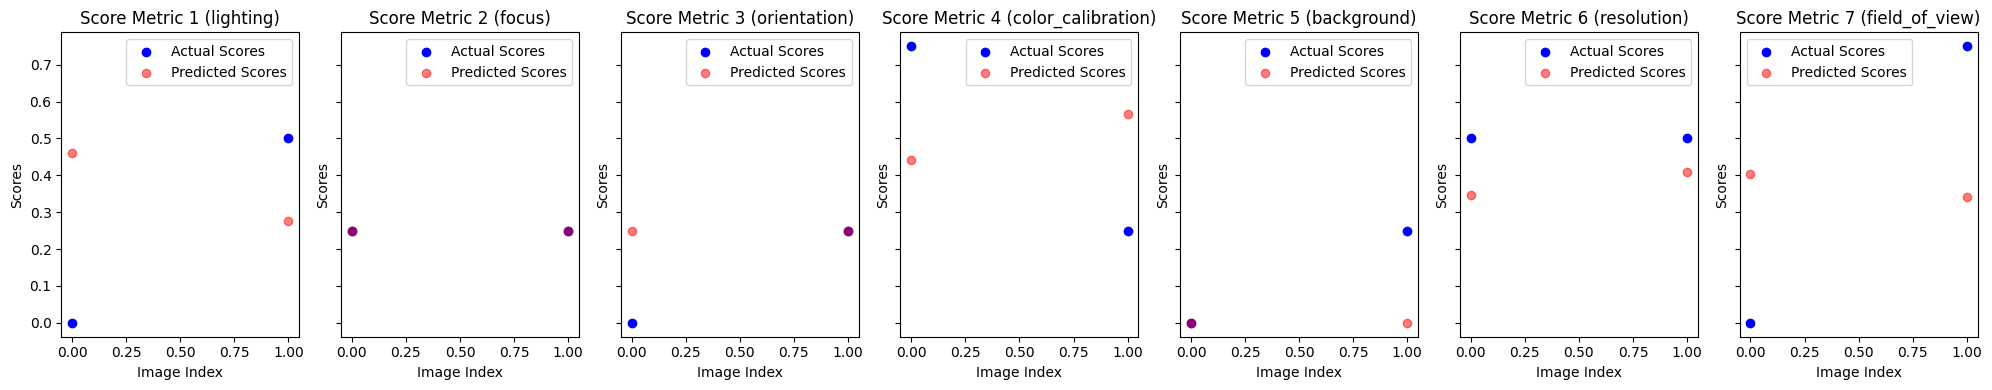

In [26]:
distortion_criteria = ["lighting", "focus", "orientation", "color_calibration", "background", "resolution", "field_of_view"]

fig, axes = plt.subplots(1, predictions.shape[1], figsize=(20, 4), sharey=True)
for i, ax in enumerate(axes):
    ax.scatter(range(len(val_scores[:, i])), val_scores[:, i], color='blue', label='Actual Scores')
    ax.scatter(range(len(predictions[:, i])), predictions[:, i], color='red', label='Predicted Scores', alpha=0.5)
    ax.set_title(f'Score Metric {i+1} ({distortion_criteria[i]})')
    ax.set_xlabel('Image Index')
    ax.set_ylabel('Scores')
    ax.legend()

plt.tight_layout()
plt.show()